In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import time
from copy import deepcopy
import matplotlib.pyplot as plt

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(torch.cuda.device_count()-1))

True
1
Tesla P100-PCIE-16GB


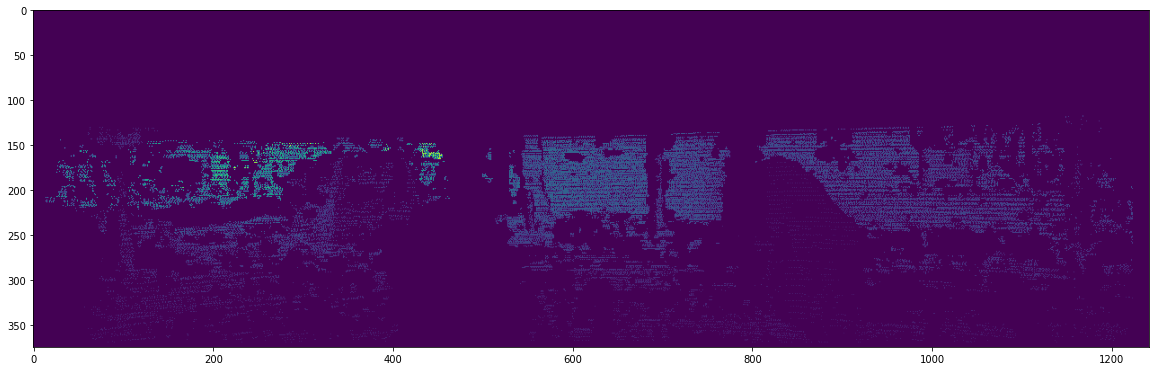

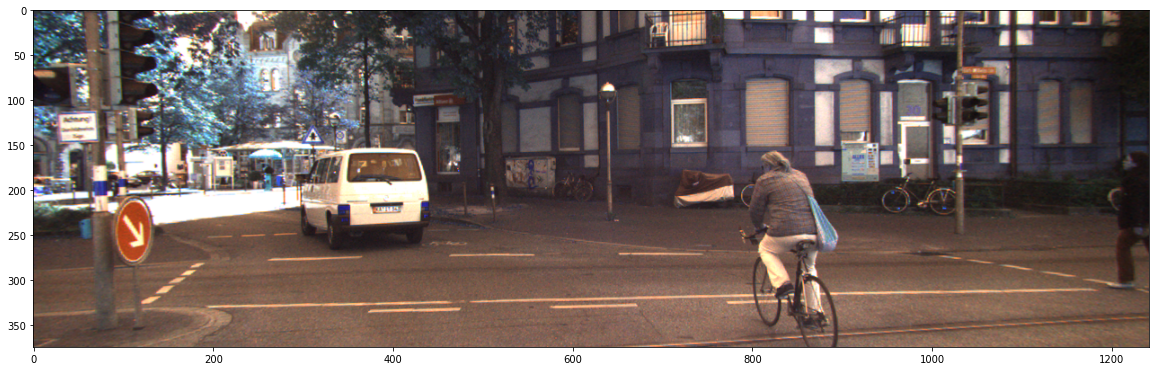

In [26]:
DATA_PATH = "drive/MyDrive"
DEPTH_PATH = os.path.join(DATA_PATH, "data_depth_self_compiled")
TRAIN_PATH = os.path.join(DEPTH_PATH, "training")
TRAIN_RGB_PATH = os.path.join(TRAIN_PATH, "image_2")
TRAIN_DEPTH_PATH = os.path.join(TRAIN_PATH, "depth")

TEST_PATH = os.path.join(DEPTH_PATH, "testing")
TEST_RGB_PATH = os.path.join(TEST_PATH, "image_2")
TEST_DEPTH_PATH = os.path.join(TEST_PATH, "depth")

rgbs = sorted(os.listdir(TEST_RGB_PATH))
depths = sorted(os.listdir(TEST_DEPTH_PATH))

x = cv2.imread(os.path.join(TEST_DEPTH_PATH, depths[3]))
x = x[:,:,0]
# print(np.unique(x))
plt.figure(figsize=(20,10))
plt.imshow(x)

x1 = cv2.imread(os.path.join(TEST_RGB_PATH, rgbs[3]))
plt.figure(figsize=(20,10))
plt.imshow(x1)

# x = cv2.imread(os.path.join(TRAIN_DEPTH_PATH, depths[3]))
# x = x[:,:,0]
# x = x.reshape(1, 375, 1242)
# x = torch.tensor(x)
# t = transforms.Compose([transforms.Resize((240, 960))])
# x = t(x)
# print(x.shape, x.dtype)
# y = x.permute(1,2,0).to(torch.int8).squeeze(2)
# print(y.shape, y.dtype)
# plt.figure(figsize=(20,10))
# plt.imshow(y)

data torch.Size([3, 120, 480]) torch.float32 torch.Size([1, 120, 480]) torch.float32


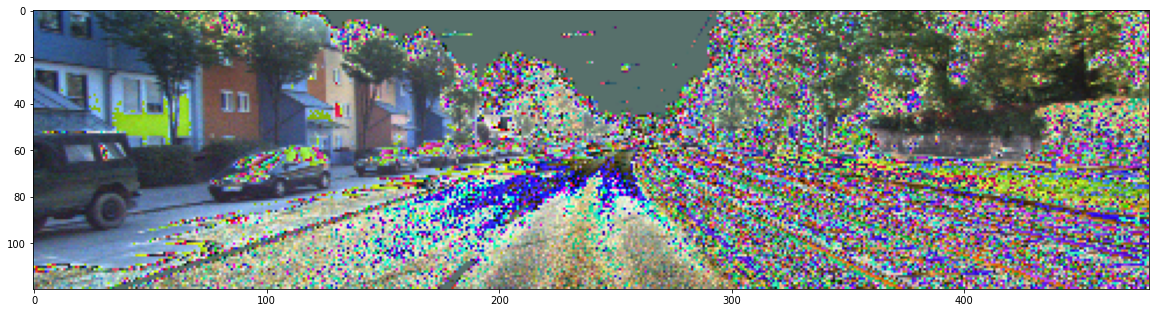

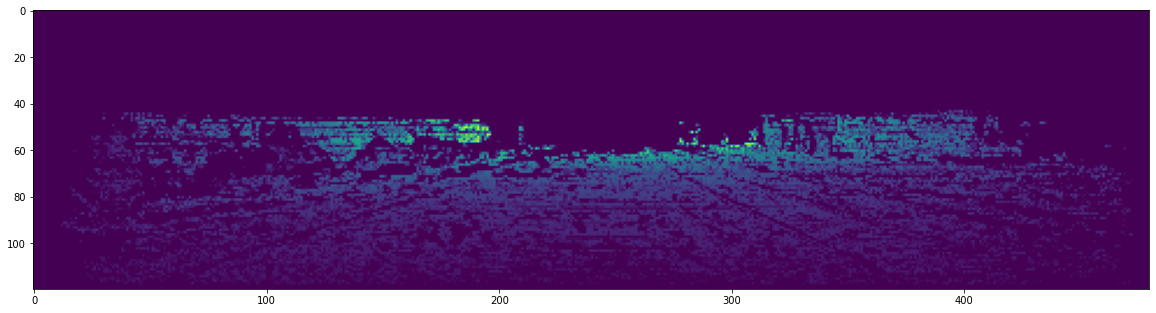

In [40]:
def read2Tensor(img_path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    img_t = read_image(img_path).to(torch.float32).unsqueeze(0).to(device)
    transform = transforms.Compose([transforms.Resize( (120, 480) ),
                   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    img_t = transform(img_t)  
    return img_t

def readLabel2Tensor(label_path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    label_t = read_image(label_path).to(torch.float32).unsqueeze(0).to(device)
    transform = transforms.Compose([transforms.Resize( (120, 480) )])
    label_t = transform(label_t)  
    return label_t    

def pred2Img(pred):
    pred = pred.squeeze(0)
    pred = pred.squeeze(0)
    pred = pred.to("cpu").to(torch.uint8)
    return pred

class KITTI_DEP(Dataset):
    def __init__(self, rgb_path, label_path, transform=transforms.Compose([transforms.Resize( (120, 480) ),
                                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
                          target_transform=transforms.Compose([transforms.Resize( (120, 480) )]),
                          device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), qmark=True):
        self.rgb_path = rgb_path
        self.rgb_names = sorted(os.listdir(self.rgb_path))         
        
        self.label_path = label_path
        self.label_names = sorted(os.listdir(self.label_path))
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.device = device
        self.qmark = qmark

    def __len__(self):
        return len(self.rgb_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.rgb_path, self.rgb_names[idx])
        depth_path = os.path.join(self.label_path, self.label_names[idx])    
        
        img = read_image(img_path)
        img = img.to(torch.float32)
        if self.qmark:
            label = cv2.imread(depth_path)
            label = label[:,:,0]
            label = label.reshape(1, *label.shape)
            label = torch.tensor(label).to(torch.float32)
        else:
            label = read_image(depth_path).to(torch.float32)
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
            
        return img.to(self.device), label.to(self.device)
    
    def example(self):
        image, label = self.__getitem__(6)
        print("data", image.shape, image.dtype, label.shape, label.dtype)        
        image = image.permute(1, 2, 0).to("cpu").to(torch.uint8)
        label = label.permute(1, 2, 0).to("cpu").to(torch.uint8).squeeze(2)
        plt.figure(figsize=(20, 10))
        plt.imshow(image)
        plt.figure(figsize=(20, 10))
        plt.imshow(label)        
        
dataset = KITTI_DEP(TRAIN_RGB_PATH, TRAIN_DEPTH_PATH, device=torch.device("cpu"))
dataset.example()

# dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
# tic = time.time()
# for i, (x, y) in enumerate(dataloader):
#     print(x.shape)
#     print(y.shape)
#     x = x.to(torch.device("cuda"))
#     y = y.to(torch.device("cuda"))
#     if i > 3:
#       break
# print("time", time.time() - tic)

In [24]:
class HorizontalBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.bn = nn.BatchNorm2d(output_dim)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DownBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        return self.max_pool(x)
    
class UpBlock(nn.Module):
    def __init__(self, input_dim):
        super().__init__()        
        self.tconv = nn.ConvTranspose2d(input_dim, input_dim//2, kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.tconv(x)
        return x
    
class ContractPath(nn.Module):
    def __init__(self, input_dim):
        super().__init__()        
        self.hb1 = HorizontalBlock(input_dim, 64)
        self.hb2 = HorizontalBlock(64, 128)
        self.hb3 = HorizontalBlock(128, 256)
        self.hb4 = HorizontalBlock(256, 512) 
        self.hb5 = HorizontalBlock(512,1024)         
        
        self.db = DownBlock()
        
    def forward(self, x):
        x1 = self.hb1(x)
        x1c = self.db(x1)
        
        x2 = self.hb2(x1c)
        x2c = self.db(x2)
        
        x3 = self.hb3(x2c)
        x3c = self.db(x3)
        
        x4 = self.hb4(x3c)
        x4c = self.db(x4) 
        
        x5 = self.hb5(x4c)
        return x5, x4, x3, x2, x1
    
class ExpandPath(nn.Module):
    def __init__(self, output_dim):
        super().__init__()        
        self.hb1 = HorizontalBlock(1024, 512)        
        self.hb2 = HorizontalBlock(512, 256)
        self.hb3 = HorizontalBlock(256, 128)
        self.hb4 = HorizontalBlock(128, 64)
        self.out_conv = nn.Conv2d(64, output_dim, kernel_size=1)
        
        self.ub1 = UpBlock(1024)
        self.ub2 = UpBlock(512)
        self.ub3 = UpBlock(256)
        self.ub4 = UpBlock(128)
        
    def forward(self, cp):
        x = cp[0]
        x = self.ub1(x) #512
        
        x_padded = torch.zeros(*cp[1].shape, device=x.device)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x
        x = torch.cat((x_padded, cp[1]), 1) #1024
        x = self.hb1(x) #512
        x = self.ub2(x) #256
        
        x_padded = torch.zeros(*cp[2].shape, device=x.device)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x        
        x = torch.cat((x_padded, cp[2]), 1) #512
        x = self.hb2(x) #256
        x = self.ub3(x) #128

        x_padded = torch.zeros(*cp[3].shape, device=x.device)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x
        x = torch.cat((x_padded, cp[3]), 1) #256
        x = self.hb3(x) #128
        x = self.ub4(x) #64   

        x_padded = torch.zeros(*cp[4].shape, device=x.device)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x
        x = torch.cat((x_padded, cp[4]), 1) #128
        x = self.hb4(x) #64
        
        x = self.out_conv(x) #num class
        
        return x
                    
    
class UNet(nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()                
        self.cp = ContractPath(input_dim)
        self.ep = ExpandPath(num_class)

    def forward(self, x):
        feat_maps = self.cp(x)
        y = self.ep(feat_maps)
        return y
        
    
x = torch.randn(1, 3, 120, 480)
unet = UNet(3, 1)
y = unet(x)
print(y.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 1, 120, 480])


In [10]:
loss_fn = nn.MSELoss()

y = torch.randn(1, 16, 120, 480)
x = torch.randn(1, 16, 120, 480)
print(x.shape, y.shape)
z = loss_fn(x, y)
z

torch.Size([1, 16, 120, 480]) torch.Size([1, 16, 120, 480])


tensor(1.9992)

In [47]:
def train(model, dataloader, num_epoch=400, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    loss_fn = nn.MSELoss()
    best_record = np.inf
    hist = []
    for epoch in range(num_epoch):
        running_loss = 0        
        tic = time.time()
        for batch_idx, (imgs, labels) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            print("batch", batch_idx, "/", len(dataloader), end='\r')
            pred = model(imgs)
            loss = loss_fn(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()           
            
            running_loss += loss.item() / len(dataloader)
            
        toc = time.time()
        hist.append(running_loss)
            
        if epoch % 1 == 0:
            print("epoch", epoch)
            print("epoch", epoch, "takes", toc-tic)
            print("running loss", running_loss)
            print("-"*50)

        if best_record > running_loss:
            print("best record", best_record)
            best_record = running_loss
            best_model = deepcopy(model)
        
        if epoch % 50 == 47:
            model_path = "trained_model_dep"+str(epoch)+".pth"
            torch.save(best_model, model_path)
            # files.download(model_path)
          
            plt.figure()
            plt.plot(hist)
            plt.savefig(str(epoch)+".jpg")
            # testViz(best_model)
            
    return best_model
        
def testViz(model, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), num_example=5):
    test_img_names = sorted(os.listdir(TEST_RGB_PATH))
    test_label_names = sorted(os.listdir(TEST_DEPTH_PATH))
    for i in range(num_example):
        img_path = os.path.join(TEST_RGB_PATH, test_img_names[i*40])
        img_t = read2Tensor(img_path)
        img = cv2.imread(img_path)

        label_path = os.path.join(TEST_DEPTH_PATH, test_label_names[i*40])
        label = cv2.imread(label_path)
        label = label[:,:,0]
        label = cv2.resize(label, (480, 120))

        tic = time.time()
        pred = model(img_t)
        pred = pred2Img(pred)
        toc = time.time()
        print("inference takes", toc-tic)

        plt.figure(figsize=(20,10))
        plt.imshow(img) 
        plt.title("img"+str(i)) 
        plt.figure(figsize=(20,10))
        plt.imshow(label) 
        plt.title("label"+str(i))         
        plt.figure(figsize=(20,10))
        plt.imshow(pred)
        plt.title("pred"+str(i)) 

        if i+1 >= num_example:
            break

# TRAINED_MODELS_PATH = os.path.join(DATA_PATH, "trained_models")
# trained_model_path = os.path.join(TRAINED_MODELS_PATH, "trained_model99.pth")
# model = torch.load(trained_model_path)
# testViz(model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0
epoch 0 takes 15.317596197128296
running loss 41.82420639764695
--------------------------------------------------
best record inf
epoch 1
epoch 1 takes 11.541650533676147
running loss 34.318456104823525
--------------------------------------------------
best record 41.82420639764695
epoch 2
epoch 2 takes 11.723989009857178
running loss 29.048003423781626
--------------------------------------------------
best record 34.318456104823525
epoch 3
epoch 3 takes 11.608295679092407
running loss 27.38969239734468
--------------------------------------------------
best record 29.048003423781626
epoch 4
epoch 4 takes 12.044049263000488
running loss 25.691453933715824
--------------------------------------------------
best record 27.38969239734468
epoch 5
epoch 5 takes 11.464732885360718
running loss 25.08651597159249
--------------------------------------------------
best record 25.691453933715824
epoch 6
epoch 6 takes 11.690771341323853
running loss 24.331192379906067
-----------------

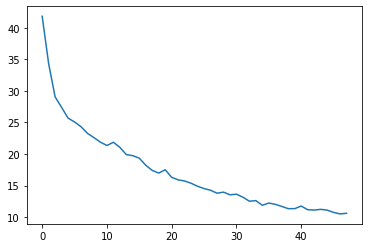

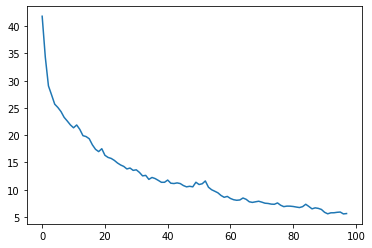

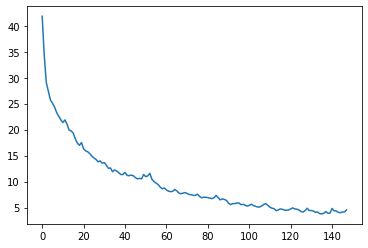

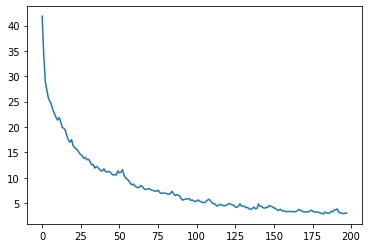

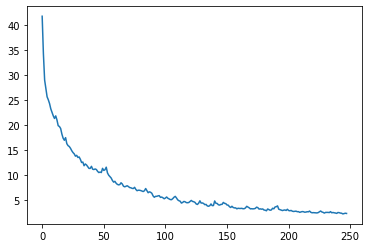

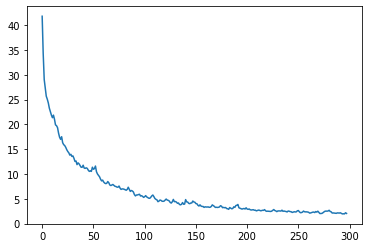

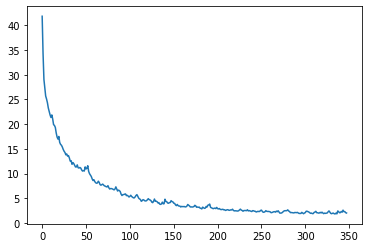

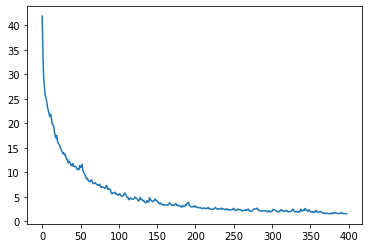

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        
# device = torch.device("cpu")        

dataset = KITTI_DEP(TRAIN_RGB_PATH, TRAIN_DEPTH_PATH, device=torch.device("cpu"))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

unet = UNet(3, 1).to(device)
model = train(unet, dataloader)

inference takes 0.019483327865600586
inference takes 0.019181013107299805
inference takes 0.0196075439453125
inference takes 0.019348621368408203


IndexError: ignored

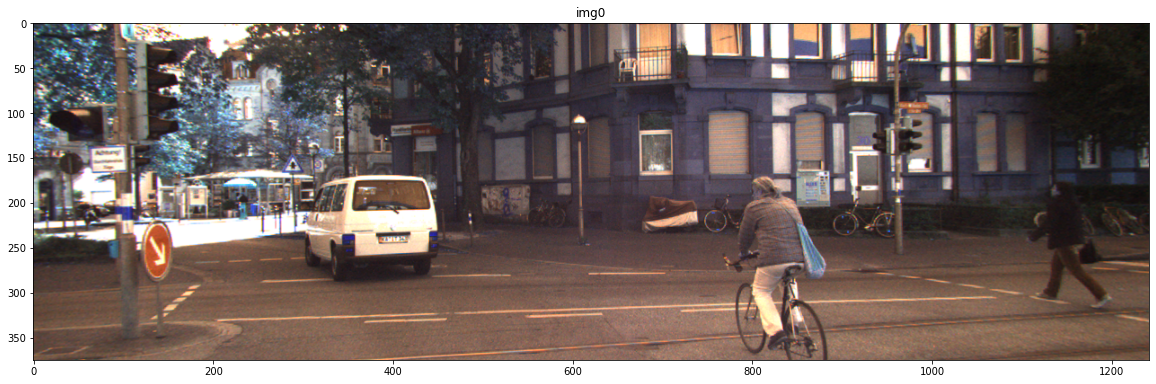

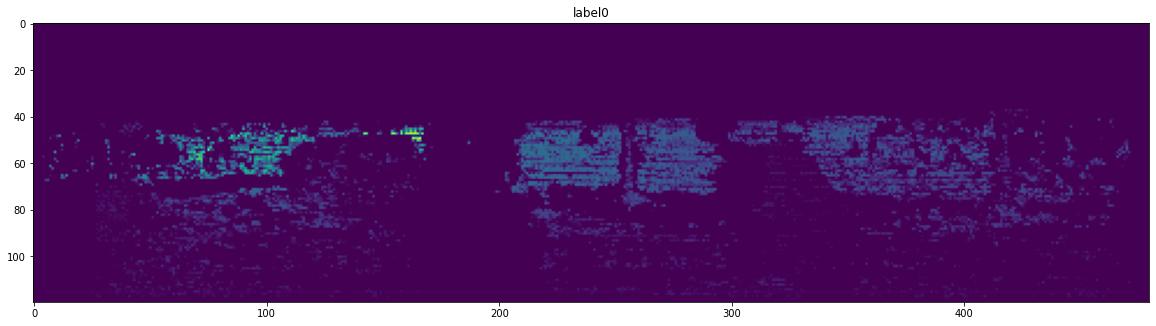

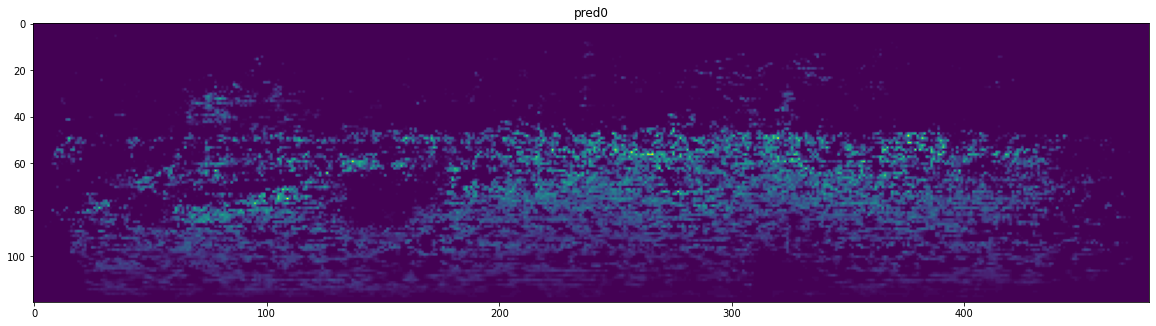

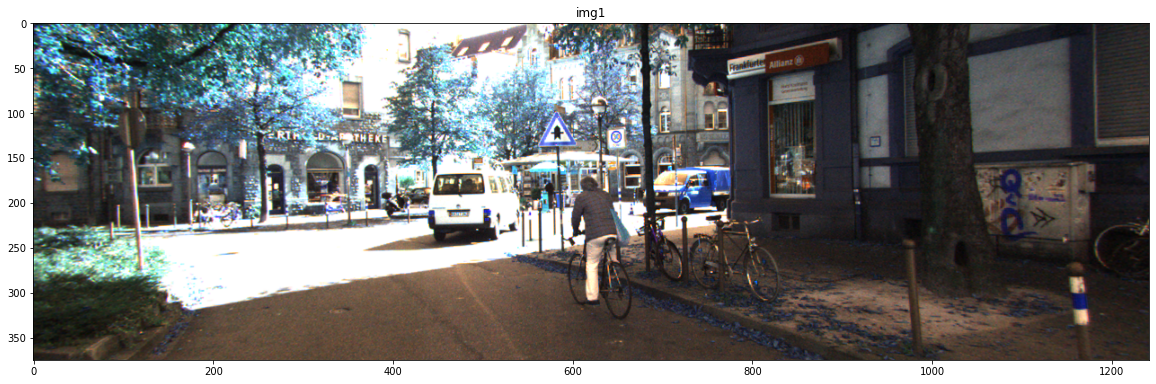

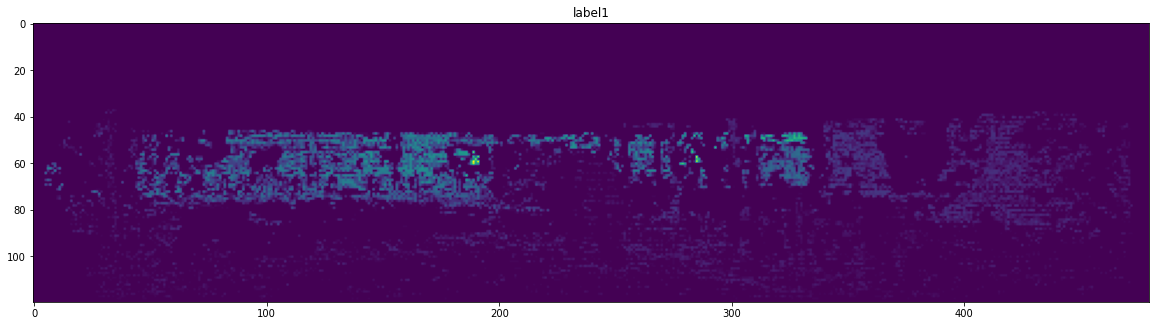

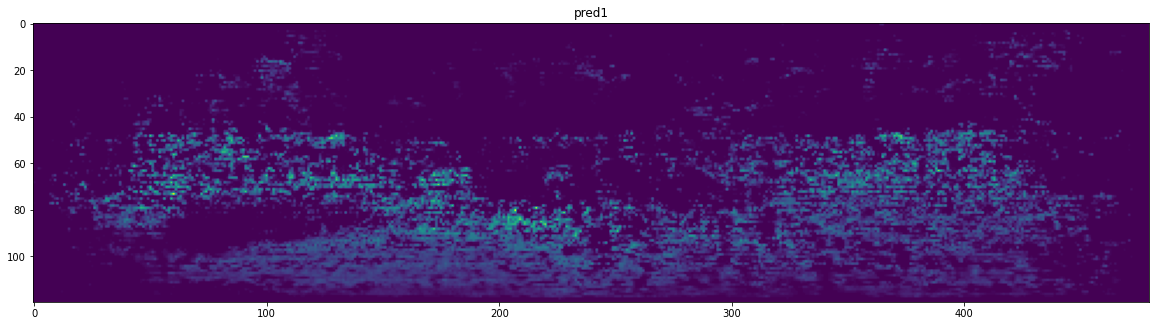

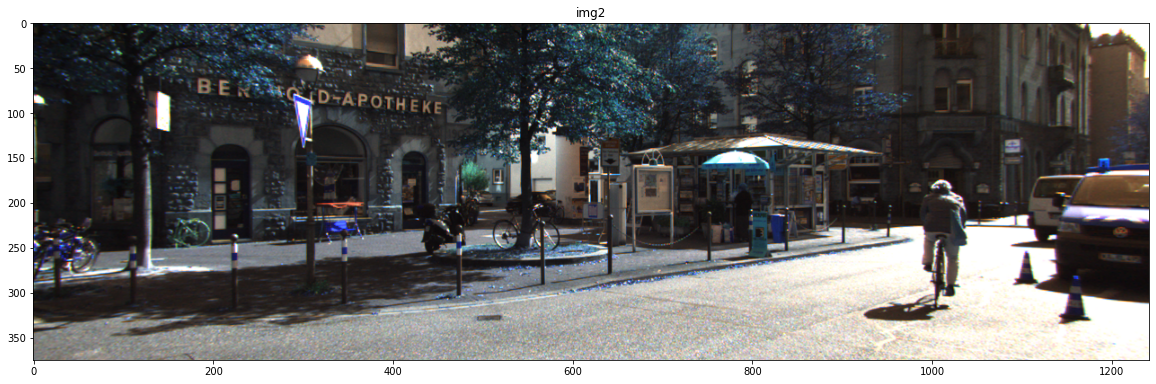

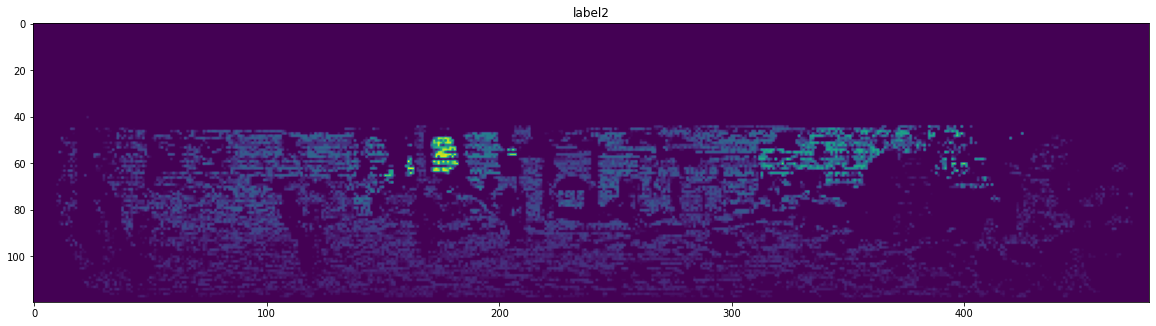

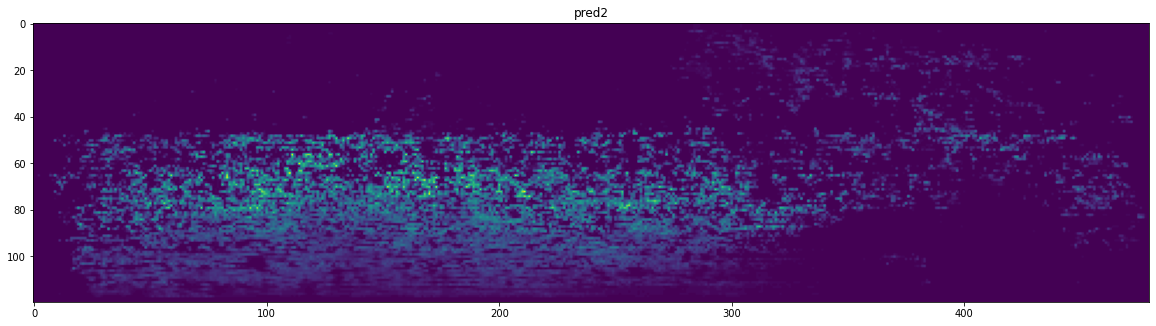

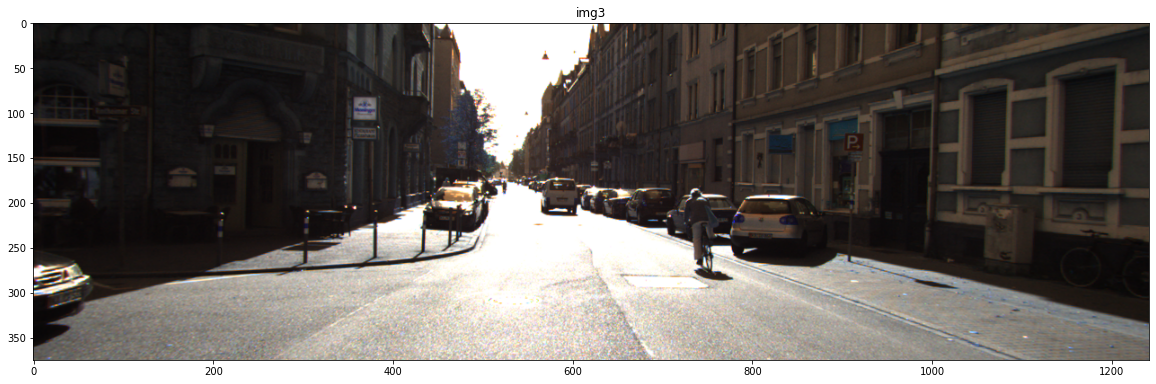

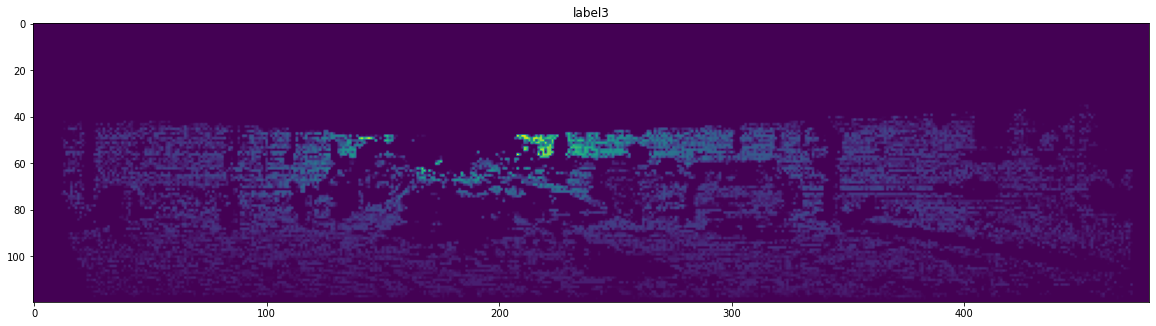

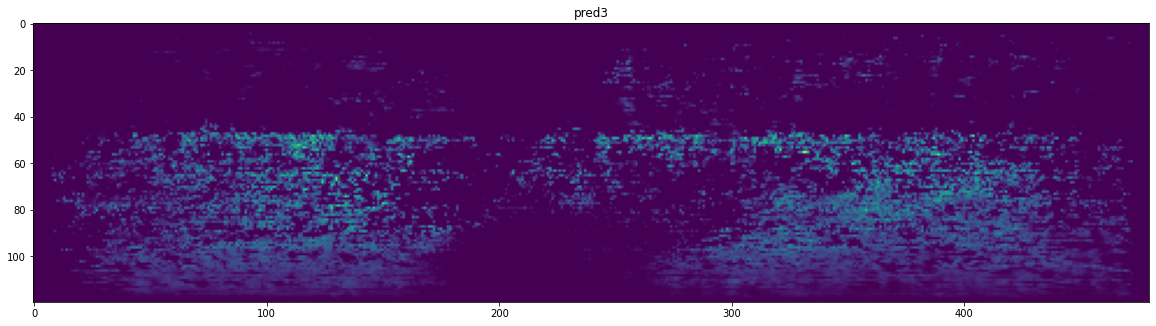

In [48]:
model = torch.load("/content/trained_model_dep397.pth")
testViz(model)